## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import numpy as np
import matplotlib.pyplot as plt

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In [3]:
type(text)

list

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()
    
assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [5]:
tokens = sorted(set(text))
len(tokens)

38

In [6]:
# plt.title('Sequence length distribution')
# plt.hist(list(map(len, text)),bins=25);

# MAX_LENGTH = max(map(len, text))
# print("max length =", MAX_LENGTH)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
# Your great code here
idx_to_token = {range(len(tokens))[i]: tokens[i] for i in range(len(tokens))}
token_to_idx = {tokens[i]: range(len(tokens))[i] for i in range(len(tokens))}
# dict <char>:<index>
# Your great code here

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [8]:
def to_matrix(text, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first=True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, text))
    #max_len += 1
    names_ix = np.zeros([len(text), max_len], dtype) + pad

    for i in range(len(text)):
        line_ix = [token_to_idx[c] for c in text[i]]
        names_ix[i, 1:len(line_ix)] = line_ix[1:]
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [9]:
print('\n'.join(text.split('\n\n')[:3]))
print(to_matrix(text.split('\n\n')[:3]))

  from fairest creatures we desire increase,
  that thereby beauty's rose might never die,
  but as the riper should by time decease,
  his tender heir might bear his memory:
  but thou, contracted to thine own bright eyes,
  feed'st thy light's flame with self-substantial fuel,
  making a famine where abundance lies,
  thy self thy foe, to thy sweet self too cruel:
  thou that art now the world's fresh ornament,
  and only herald to the gaudy spring,
  within thine own bud buriest thy content,
  and tender churl mak'st waste in niggarding:
    pity the world, or else this glutton be,
    to eat the world's due, by the grave and thee.
  ii
  when forty winters shall besiege thy brow,
  and dig deep trenches in thy beauty's field,
  thy youth's proud livery so gazed on now,
  will be a tatter'd weed of small worth held:
  then being asked, where all thy beauty lies,
  where all the treasure of thy lusty days;
  to say, within thine own deep sunken eyes,
  were an all-eating shame, and t

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [10]:
import torch, torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

D:\AnacondaGO\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
class RNN_poetry(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size) #one-hot на матрицу
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        
        x_and_h = torch.cat([x_emb, h_prev], dim=1) #сконкатенировали
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next) #функция активации
        assert h_next.size() == h_prev.size()
      
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [12]:
def rnn_loop(char_rnn, batch_ix):
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [13]:
from IPython.display import clear_output
from random import sample

char_rnn = RNN_poetry()
opt = torch.optim.Adam(char_rnn.parameters())
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_idx[' '])

history = []

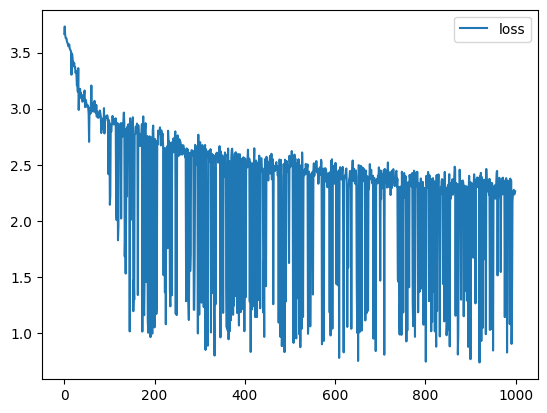

In [14]:
for i in range(1000):
    batch_ix = to_matrix(sample(text.split('\n\n'), 2))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logits_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logits = logits_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    #loss = loss_func(predictions_logits.reshape((-1, len(tokens))),actual_next_tokens.reshape(-1))
    loss = loss_func(predictions_logits.contiguous().view(-1, len(tokens)), actual_next_tokens.contiguous().view(-1))
    loss.backward()
    opt.step()
    
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [15]:
MAX_LENGTH = 500
def generate_sample(char_rnn, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        #print(x_sequence[:, -1].shape, hid_state.shape)
        hid_state, out = char_rnn(x_sequence[:, :, i][0], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        #print(x_sequence.shape, x_sequence, hid_state.shape)
        hid_state, out = char_rnn(x_sequence[:, :, -1][0], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        #print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        #print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix[None,:,:]], dim=2)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [16]:
# An example of generated text.
print(generate_sample(char_rnn, ' no', temperature=0.8))

 novtent,
t;

s,
und,
us,;
s's'dssed,
unsel'nsly
ureser.
sn'd,
ut,
rer'dntouttred-staro'd'stirss'slyered'stoy,
nd,
n,
r
ud
s,
us,
t'dese.
urg,
ustorson,
t
f,
us?
r'grse,
rl
g
,
-twostroigy,
s'd;
urrre,
'gtategrls.
u,
u
s,
ng'd,
ug
st,
.

't
r'f'den.
;


s;
un,
ursc
rs,
ung,
sg
,
'd.
ut,
ng'd,
'nd,
ng'dd;
urlsted.
,

st;

,
'dd
t,
n.

;
-)?)) bxqixxiiiviiiiindsre,
ngru,
ursoutereldathe;
nd,
d
,
;
;

n.
:
(z z:vvixciiixiiiinessersters,
p
rs;
'nd;
y,
n.
ungrld
ringuen,
ng
;
se'terstay;
'gh
!,
n,
nd


**Какой-то бред!**

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
class LSTM_poetry(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size) #one-hot на матрицу
        #self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.lstm = nn.LSTM(embedding_size, rnn_num_units, batch_first=True)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        x_emb = self.embedding(x)
        h, out = self.lstm(x_emb)
      
        logits = self.rnn_to_logits(h)
        
        return F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [ ]:
# Your beautiful code here
# class LSTM_poetry(nn.Module):
#     def __init__(self, num_tokens=len(tokens), emb_size=16, rnn_num_units=64):
#         super(self.__class__, self).__init__()
#         self.emb = nn.Embedding(num_tokens, emb_size)
#         self.rnn = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
#         self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
#     def forward(self, x):
#         assert isinstance(x.data, torch.LongTensor)
#         h_seq, _ = self.rnn(self.emb(x))
#         next_logits = self.hid_to_logits(h_seq)
#         next_logp = F.log_softmax(next_logits, dim=-1)
#         return next_logp
    
#     def initial_state(self, batch_size):
#         return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [ ]:
char_lstm = LSTM_poetry()
opt = torch.optim.Adam(char_lstm.parameters())
loss_func = nn.NLLLoss()
history = []

In [ ]:
for i in range(1000):
    batch_ix = to_matrix(sample(text.split('\n\n'), 32))
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logits_seq = char_lstm(batch_ix)
    
    # compute loss
    predictions_logits = logits_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    #loss = loss_func(predictions_logits.reshape((-1, len(tokens))),actual_next_tokens.reshape(-1))
    loss = loss_func(predictions_logits.contiguous().view(-1, len(tokens)), actual_next_tokens.contiguous().view(-1))
    loss.backward()
    opt.step()
    
    opt.zero_grad()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "LSTM didn't converge."

In [ ]:
def generate_sample_LSTM(model, seed_phrase=' ', max_length=500, temperature=1.0):
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    
    model.eval()
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out = model(x_sequence[:, :, i][0])
    
    #start generating
    for i in range(max_length - len(seed_phrase)):
        out = model(x_sequence[:, :, -1][0])
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix[None, :, :]], dim=2)
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0][0]])

In [ ]:
for i in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(i, '\n', generate_sample_LSTM(char_lstm, ' no', max_length=300, temperature=0.8), '\n\n')

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
# Text generation with different temperature values here

**Снова какая-то дичь♥**

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here
# torch.save(char_lstm, './LSTM.pth')
# model_loaded = torch.load('./LSTM.pth')
# print(generate_sample_LSTM(model_loaded))

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)